# Twitter Sentiment Analysis

Importing required Libraries

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout # type: ignore
from keras.utils import to_categorical # type: ignore

In [3]:
training_data = pd.read_csv('twitter_training.csv')
validation_data = pd.read_csv('twitter_validation.csv')

In [4]:
training_data.shape

(74681, 4)

In [5]:
validation_data.shape

(999, 4)

# Data Preprocessing

In [8]:
training_data.columns = ['ID', 'Entity', 'Sentiment', 'Message']
validation_data.columns = ['ID', 'Entity', 'Sentiment', 'Message']

In [9]:
training_data.head()

,ID,Entity,Sentiment,Message
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [10]:
validation_data.head()

,ID,Entity,Sentiment,Message
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [12]:
training_data.dtypes

ID            int64
Entity       object
Sentiment    object
Message      object
dtype: object

In [13]:
training_data.describe()

,ID
count,74681.000000
mean,6432.640149
std,3740.423819
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [14]:
training_data['Message'] = training_data['Message'].astype(str).fillna('')
validation_data['Message'] = validation_data['Message'].astype(str).fillna('')

In [18]:
training_data.isnull().sum()

ID           0
Entity       0
Sentiment    0
Message      0
dtype: int64

# Explanatory Data Analysis

# EDA 1: Sentiment Distribution

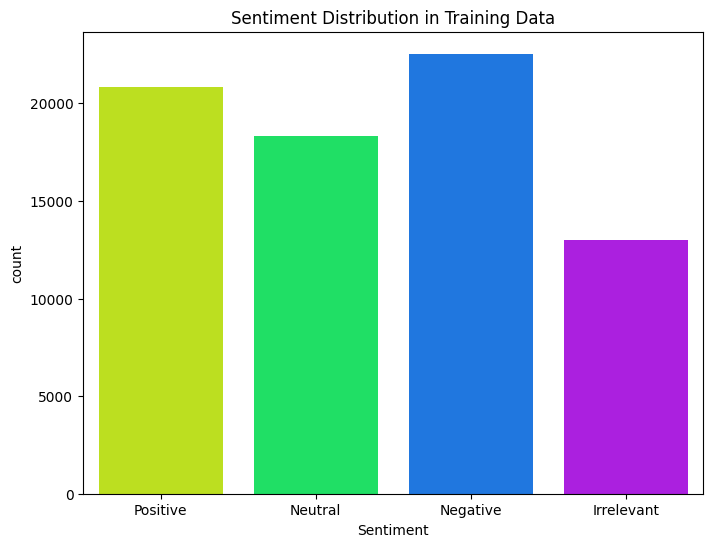

In [47]:
sentiment_counts = training_data['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=training_data, palette=sns.color_palette("hsv", len(sentiment_counts)))
plt.title('Sentiment Distribution in Training Data')
plt.show()

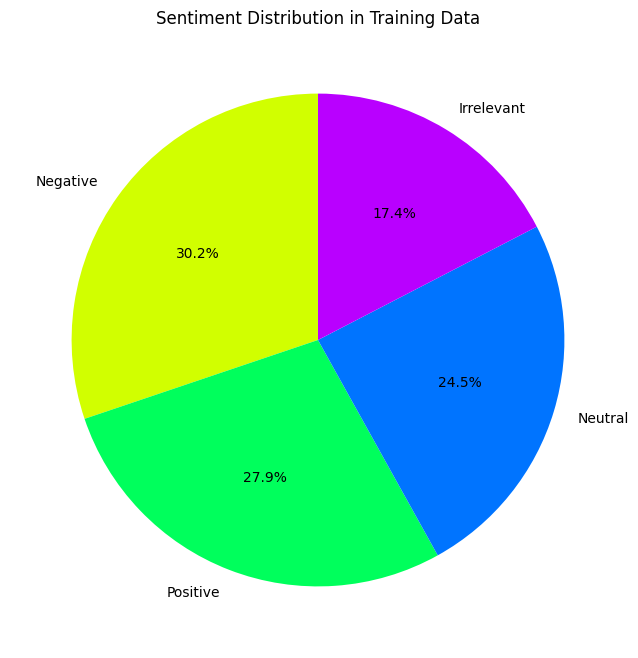

In [48]:
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("hsv", len(sentiment_counts)))
plt.title('Sentiment Distribution in Training Data')
plt.show()

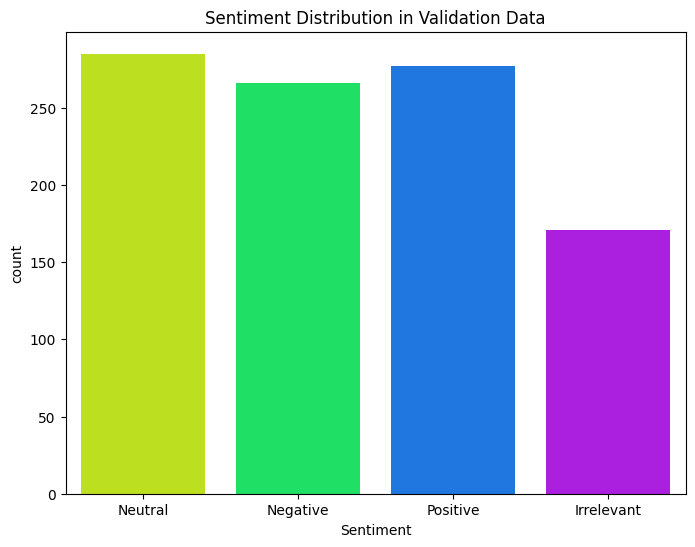

In [49]:
sentiment_counts = validation_data['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=validation_data, palette=sns.color_palette("hsv", len(sentiment_counts)))
plt.title('Sentiment Distribution in Validation Data')
plt.show()

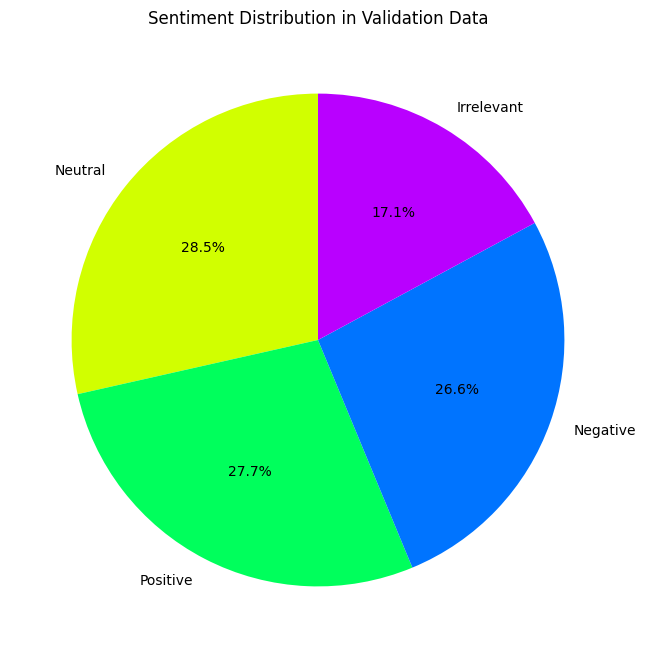

In [50]:
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("hsv", len(sentiment_counts)))
plt.title('Sentiment Distribution in Validation Data')
plt.show()    

# EDA 2: Frequency of All Entities in Training Data

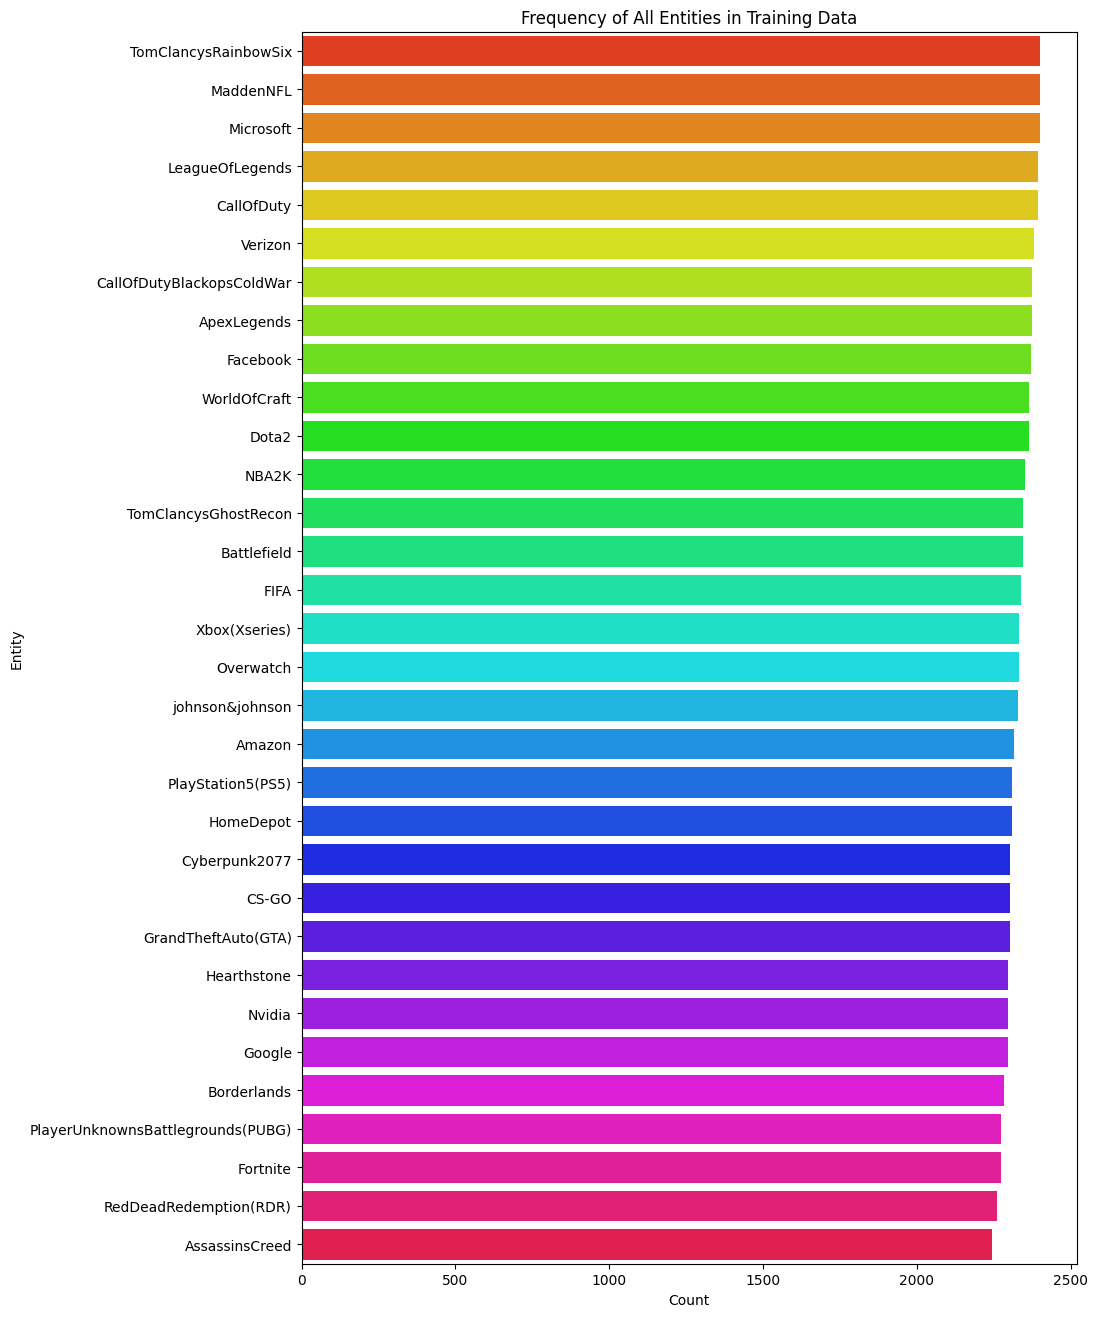

In [31]:
entity_counts = training_data['Entity'].value_counts()

plt.figure(figsize=(10, len(entity_counts) / 2))  
sns.barplot(y=entity_counts.index, x=entity_counts.values, orient='h',palette=sns.color_palette("hsv", len(entity_counts)))
plt.title('Frequency of All Entities in Training Data')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

# EDA 3: Stacked Bar Chart of Sentiment Distribution by Entity

<Figure size 1200x800 with 0 Axes>

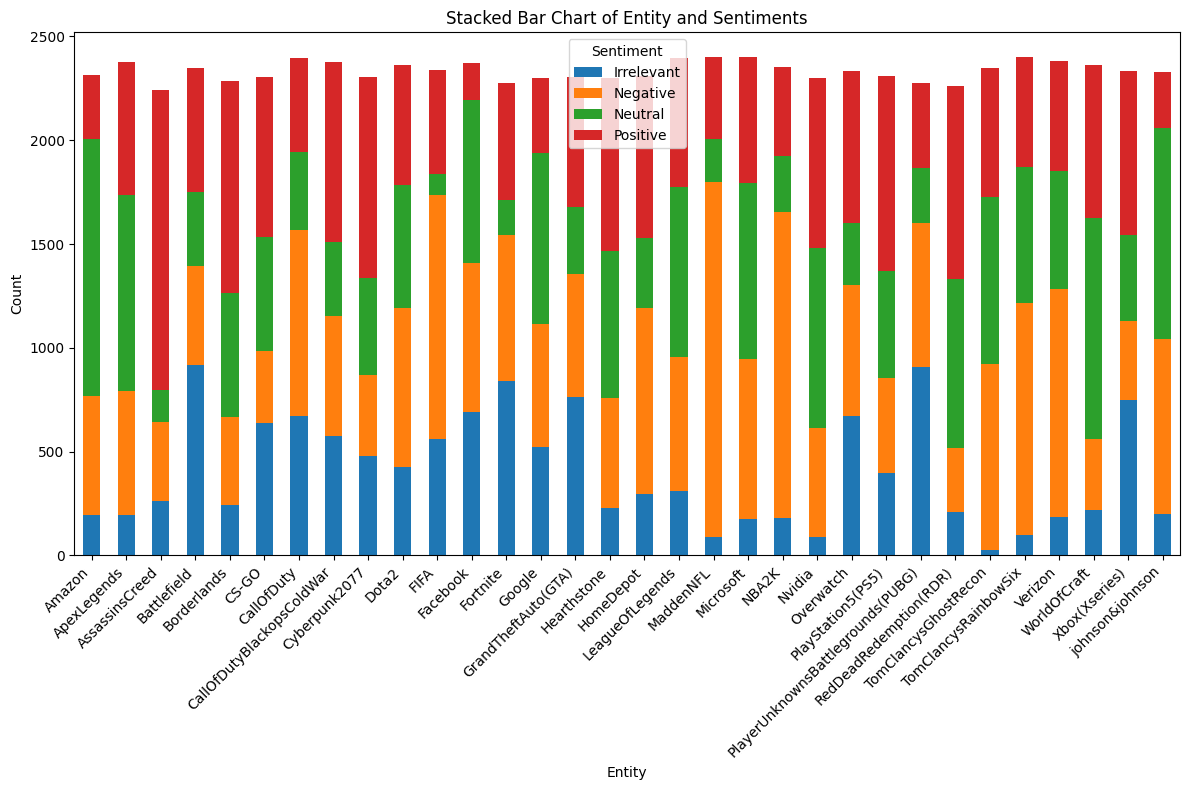

In [51]:
entity_sentiment_counts = pd.crosstab(training_data['Entity'], training_data['Sentiment'])

plt.figure(figsize=(12, 8))
entity_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of Entity and Sentiments')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# EDA 4: Message Length Distribution

In [53]:
training_data['Message_Length'] = training_data['Message'].apply(len)
validation_data['Message_Length'] = validation_data['Message'].apply(len)

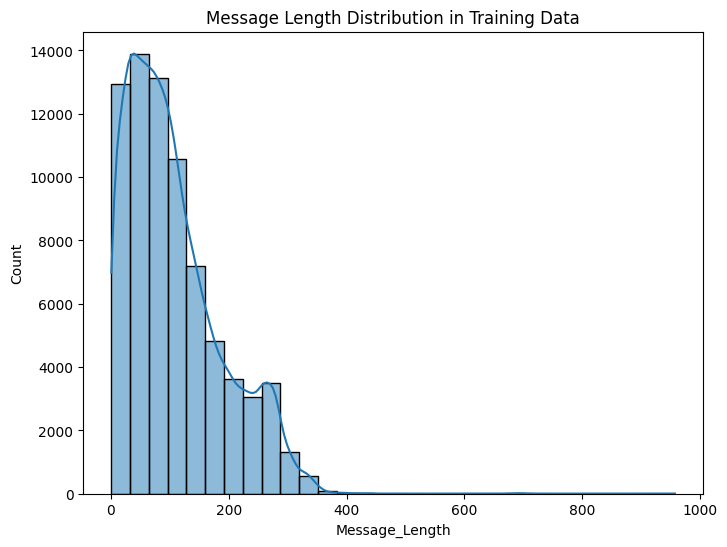

In [62]:
plt.figure(figsize=(8, 6))
sns.histplot(training_data['Message_Length'], kde=True, bins=30)
plt.title('Message Length Distribution in Training Data')
plt.show()

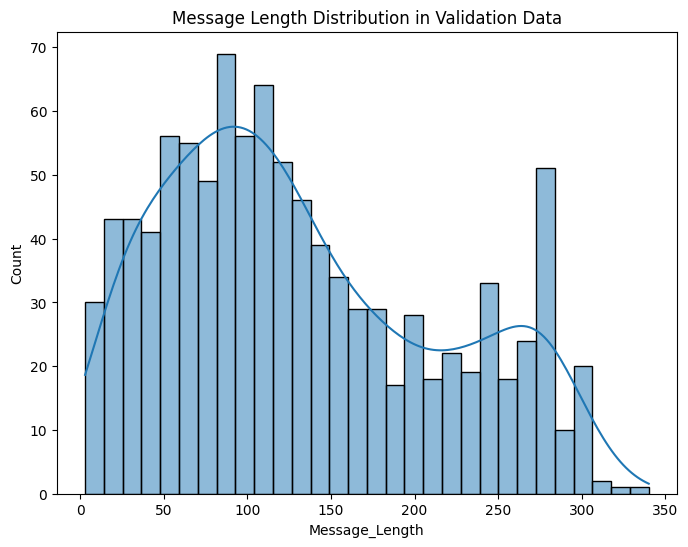

In [63]:
plt.figure(figsize=(8, 6))
sns.histplot(validation_data['Message_Length'], kde=True, bins=30)
plt.title('Message Length Distribution in Validation Data')
plt.show()

# EDA 5: Wordcloud

Filter messages based on sentiment categories

In [64]:
positive_messages = ' '.join(training_data[training_data['Sentiment'] == 'Positive']['Message'])
negative_messages = ' '.join(training_data[training_data['Sentiment'] == 'Negative']['Message'])
neutral_messages = ' '.join(training_data[training_data['Sentiment'] == 'Neutral']['Message'])
irrelevant_messages = ' '.join(training_data[training_data['Sentiment'] == 'Irrelevant']['Message'])

Create word clouds for each sentiment category

In [65]:
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_messages)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_messages)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_messages)
wordcloud_irrelevant = WordCloud(width=800, height=400, background_color='white').generate(irrelevant_messages)

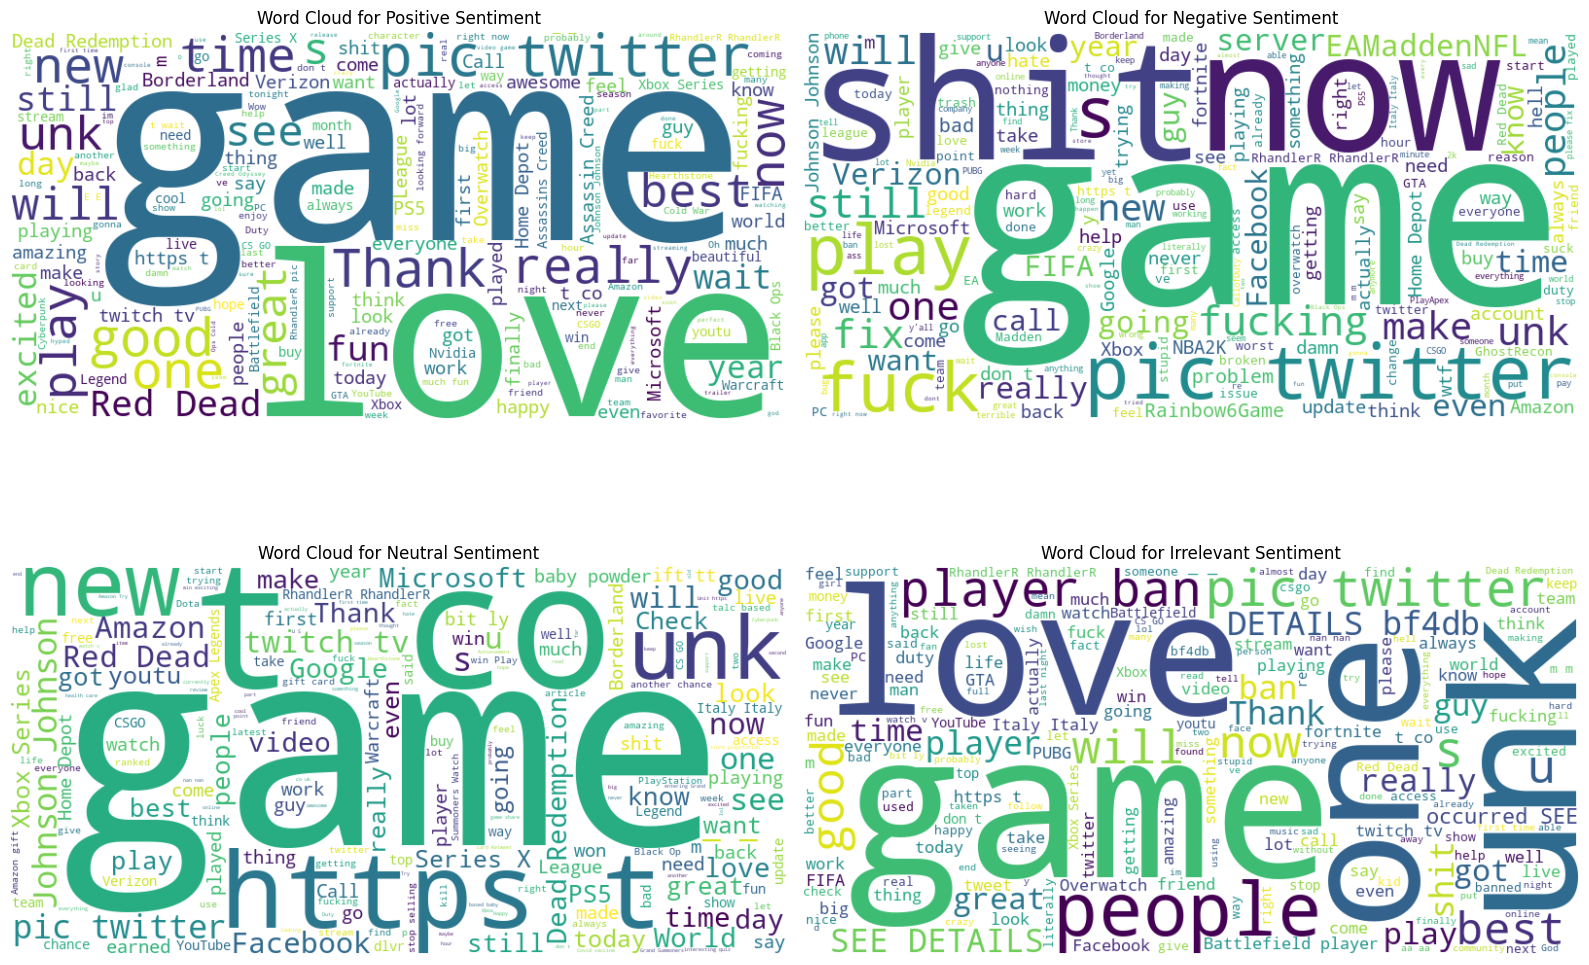

In [66]:
# Set up subplots to show all word clouds
plt.figure(figsize=(16, 12))

# Plot Positive WordCloud
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

# Plot Negative WordCloud
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

# Plot Neutral WordCloud
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud for Neutral Sentiment')
plt.axis('off')

# Plot Irrelevant WordCloud
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_irrelevant, interpolation='bilinear')
plt.title('Word Cloud for Irrelevant Sentiment')
plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()

# TF-IDF Vectorization

Preprocess the text using TF-IDF

In [70]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

Transform the training and validation messages

In [71]:
X_train_tfidf = tfidf_vectorizer.fit_transform(training_data['Message'])
X_validation_tfidf = tfidf_vectorizer.transform(validation_data['Message'])

Target labels

In [72]:
y_train = training_data['Sentiment']
y_validation = validation_data['Sentiment']

# K-Means++ Clustering

In [73]:
wcss = []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train_tfidf)
    wcss.append(kmeans.inertia_) 

Plot the WCSS 

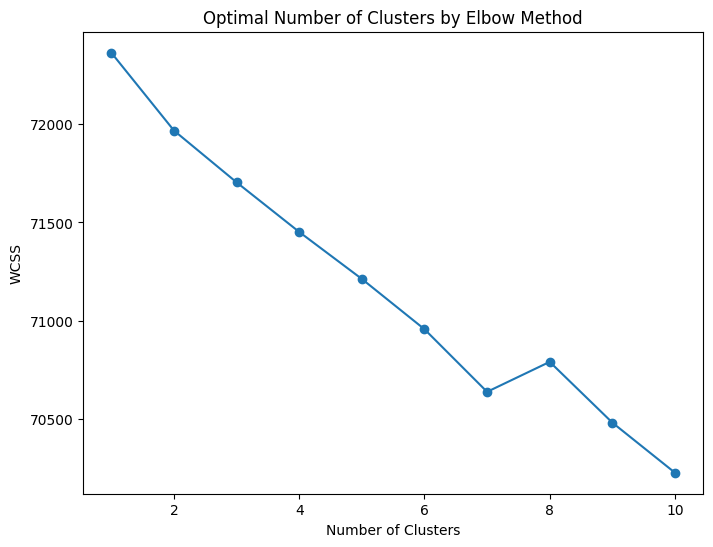

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Optimal Number of Clusters by Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Initialize the KMeans model

In [75]:
kmeans_model = KMeans(n_clusters=6, init='k-means++', random_state=42)

Train the model

In [76]:
kmeans_model.fit(X_train_tfidf)

KMeans(n_clusters=6, random_state=42)

Predict cluster labels for the validation set

In [77]:
cluster_labels = kmeans_model.predict(X_train_tfidf)

In [78]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

Plot the PCA result with cluster labels

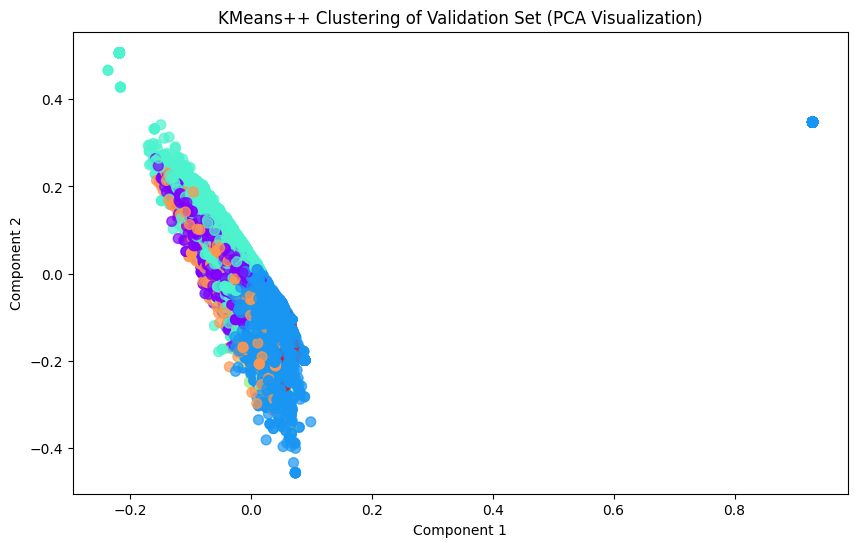

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels, cmap='rainbow', s=50, alpha=0.7)
plt.title('KMeans++ Clustering of Validation Set (PCA Visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [80]:
import numpy as np
np.unique(cluster_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([17626, 32699, 14709,  1521,  6713,  1413], dtype=int64))

# Naive Bayes Classifier

In [81]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_validation_tfidf)

In [82]:
accuracy_nb = accuracy_score(y_validation, y_pred_nb)
report_nb = classification_report(y_validation, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Naive Bayes Classification Report:\n", report_nb)

Naive Bayes Accuracy: 0.7137137137137137
Naive Bayes Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.83      0.51      0.63       171
    Negative       0.66      0.83      0.74       266
     Neutral       0.78      0.62      0.69       285
    Positive       0.68      0.82      0.75       277

    accuracy                           0.71       999
   macro avg       0.74      0.70      0.70       999
weighted avg       0.73      0.71      0.71       999



# Logistic Regression

In [83]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_validation_tfidf)

In [84]:
accuracy_lr = accuracy_score(y_validation, y_pred_lr)
report_lr = classification_report(y_validation, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Classification Report:\n", report_lr)

Logistic Regression Accuracy: 0.8168168168168168
Logistic Regression Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.82      0.73      0.77       171
    Negative       0.79      0.88      0.83       266
     Neutral       0.87      0.77      0.82       285
    Positive       0.80      0.86      0.82       277

    accuracy                           0.82       999
   macro avg       0.82      0.81      0.81       999
weighted avg       0.82      0.82      0.82       999



# Random Forest

In [85]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth= 100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_validation_tfidf)

In [86]:
accuracy_rf = accuracy_score(y_validation, y_pred_rf)
report_rf = classification_report(y_validation, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", report_rf)

Random Forest Accuracy: 0.938938938938939
Random Forest Classification Report:
               precision    recall  f1-score   support

  Irrelevant       1.00      0.88      0.94       171
    Negative       0.95      0.96      0.95       266
     Neutral       0.91      0.94      0.93       285
    Positive       0.92      0.95      0.94       277

    accuracy                           0.94       999
   macro avg       0.95      0.93      0.94       999
weighted avg       0.94      0.94      0.94       999



# Decision Tree

Initialize the Decision Tree model

In [87]:
dt_model = DecisionTreeClassifier(random_state=42)

Train the model

In [88]:
dt_model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(random_state=42)

Make predictions on the validation set

In [89]:
y_pred_dt = dt_model.predict(X_validation_tfidf)

Evaluate the model

In [90]:
accuracy_dt = accuracy_score(y_validation, y_pred_dt)
report_dt = classification_report(y_validation, y_pred_dt)

Classification Report 

In [91]:
print("Decision Tree Model Accuracy:", accuracy_dt)
print("Decision Tree Model Classification Report:\n", report_dt)

Decision Tree Model Accuracy: 0.8868868868868869
Decision Tree Model Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.91      0.82      0.87       171
    Negative       0.90      0.95      0.92       266
     Neutral       0.87      0.86      0.86       285
    Positive       0.88      0.90      0.89       277

    accuracy                           0.89       999
   macro avg       0.89      0.88      0.88       999
weighted avg       0.89      0.89      0.89       999



# ANN

Encode Sentiments into numerical values

In [92]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_validation_encoded = encoder.transform(y_validation)

One-hot encoding

In [93]:
y_train_categorical = to_categorical(y_train_encoded)
y_validation_categorical = to_categorical(y_validation_encoded)

Build the neural network model

In [95]:
model = Sequential()

model.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [96]:
history = model.fit(
    X_train_tfidf.toarray(), y_train_categorical, epochs=10, batch_size=64, validation_data=(X_validation_tfidf.toarray(), y_validation_categorical)
    )

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5663 - loss: 1.0167 - val_accuracy: 0.9249 - val_loss: 0.2693
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8611 - loss: 0.3822 - val_accuracy: 0.9600 - val_loss: 0.1351
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.9243 - loss: 0.2071 - val_accuracy: 0.9720 - val_loss: 0.1167
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9384 - loss: 0.1595 - val_accuracy: 0.9700 - val_loss: 0.1215
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9464 - loss: 0.1329 - val_accuracy: 0.9710 - val_loss: 0.1184
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.9489 - loss: 0.1216 - val_accuracy: 0.9710 - val_loss: 0.1212
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9514 - loss: 0.1161 - val_accuracy: 0.9710 - val_loss: 0.1166
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9512 -

Make predictions on the validation set

In [97]:
y_pred_ann = model.predict(X_validation_tfidf.toarray())
y_pred_ann_labels = np.argmax(y_pred_ann, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Decode the predicted labels

In [98]:
y_pred_labels = encoder.inverse_transform(y_pred_ann_labels)

Evaluate the model

In [99]:
accuracy_ann = accuracy_score(y_validation, y_pred_labels)
report_ann = classification_report(y_validation, y_pred_labels)

Classification Report 

In [100]:
print("ANN Model Accuracy:", accuracy_ann)
print("ANN Model Classification Report:\n", report_ann)

ANN Model Accuracy: 0.968968968968969
ANN Model Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.95      0.95      0.95       171
    Negative       0.98      0.97      0.98       266
     Neutral       0.98      0.98      0.98       285
    Positive       0.96      0.97      0.96       277

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999



Plot the accuracy over epochs

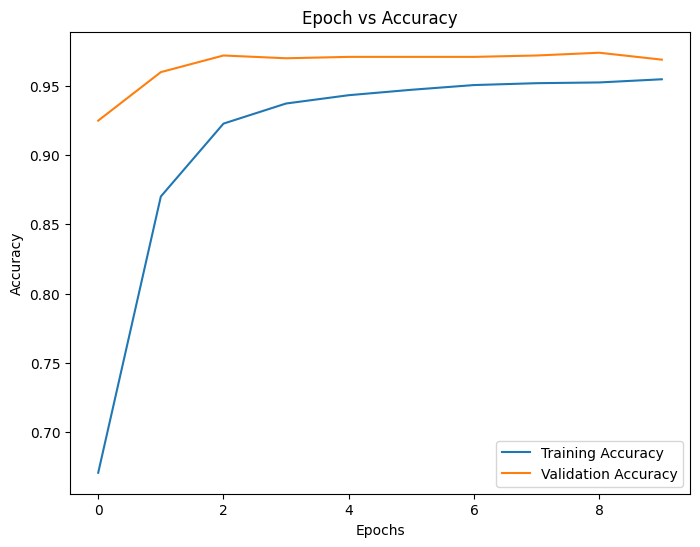

In [103]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plot the loss over epochs

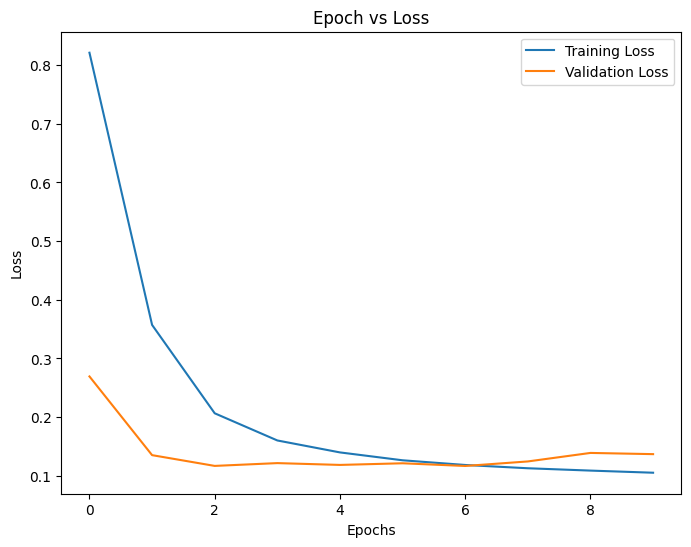

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Conclusion: The model that delivers the best performance overall is Artificial Neural Network (ANN) with 97% accuracy